<a href="https://colab.research.google.com/github/jorgecaraballo3000/Estrategias_Disruptivas/blob/main/disruptive_innovation_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disruptive Innovation: Incumbent vs. Disruptor (Python Simulation)

This notebook models a classic disruptive innovation scenario:

*   A disruptor starts in a low‑end niche (cheap, initially lower performance) and improves along an S-curve.

*   An incumbent improves slowly via sustaining innovation.

*   Two customer segments: low-end (price‑sensitive) and mainstream (performance‑sensitive).

*   Choice is modeled with a simple multinomial logit (softmax) within each segment, yielding market shares.

*   We track market shares, performance, prices, and highlight key stages (niche traction, “good enough”, and overtake).




---


Tip: Feel free to tweak parameters in the “Parameters” cell to explore
different disruption paths.

In [4]:
# Parameters
T = 40                # periods (e.g., quarters/years)
perf_inc_start = 0.85 # incumbent initial performance
perf_inc_growth = 0.003  # sustaining innovation rate

# Disruptor logistic S-curve parameters
L = 0.95   # max attainable performance
k = 0.25   # steepness
t0 = 18    # inflection point

# Prices
price_inc_base = 1.00
price_dis_base = 0.55

# Market segments (weights)
seg_low = 0.35   # low-end (price-sensitive)
seg_main = 1 - seg_low

# Utility weights: U = w_perf * performance - w_price * price
w_perf_low, w_price_low   = 0.6, 1.2
w_perf_main, w_price_main = 1.3, 0.7

# Network effect strength for disruptor in low-end
network_effect_strength = 0.10

In [5]:
# Simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
t = np.arange(T)

# Performance
perf_inc = perf_inc_start + perf_inc_growth * t
perf_dis = (L / (1 + np.exp(-k * (t - t0)))) * 0.95  # capped under 1.0

# Prices (no explicit color styles; mild seasonal noise)
price_inc = np.full(T, price_inc_base) + 0.01 * np.sin(t/4)
price_dis = np.full(T, price_dis_base) + 0.02 * np.sin(t/6)

# Shares via segment-weighted softmax
share_inc = np.zeros(T)
share_dis = np.zeros(T)
installed_base_dis = 0.0

def softmax(u1, u2):
    m = max(u1, u2)
    e1, e2 = np.exp(u1 - m), np.exp(u2 - m)
    s = e1 + e2
    return e1 / s, e2 / s

for tau in range(T):
    U_low_inc = w_perf_low * perf_inc[tau] - w_price_low * price_inc[tau]
    U_low_dis = w_perf_low * perf_dis[tau] - w_price_low * price_dis[tau]
    U_low_dis += network_effect_strength * installed_base_dis  # network effect

    U_main_inc = w_perf_main * perf_inc[tau] - w_price_main * price_inc[tau]
    U_main_dis = w_perf_main * perf_dis[tau] - w_price_main * price_dis[tau]

    p_low_inc, p_low_dis   = softmax(U_low_inc, U_low_dis)
    p_main_inc, p_main_dis = softmax(U_main_inc, U_main_dis)

    share_inc[tau] = seg_low * p_low_inc + seg_main * p_main_inc
    share_dis[tau] = 1 - share_inc[tau]

    installed_base_dis = 0.92 * installed_base_dis + 0.08 * share_dis[tau]

import pandas as pd
df = pd.DataFrame({
    "t": t,
    "Perf_Incumbent": perf_inc,
    "Perf_Disruptor": perf_dis,
    "Price_Incumbent": price_inc,
    "Price_Disruptor": price_dis,
    "Share_Incumbent": share_inc,
    "Share_Disruptor": share_dis,
})

# Stage markers
stage_entry = int(np.argmax(share_dis > 0.20)) if np.any(share_dis > 0.20) else None
stage_good_enough = int(np.argmax(perf_dis >= perf_inc * 0.95)) if np.any(perf_dis >= perf_inc * 0.95) else None
stage_overtake = int(np.argmax(share_dis > 0.50)) if np.any(share_dis > 0.50) else None

stages = {
    "Niche traction (share > 20%)": stage_entry,
    "'Good enough' performance (~95% of incumbent)": stage_good_enough,
    "Overtakes incumbent (share > 50%)": stage_overtake
}

df.head(10)


,t,Perf_Incumbent,Perf_Disruptor,Price_Incumbent,Price_Disruptor,Share_Incumbent,Share_Disruptor
0,0,0.850,0.009916,1.000000,0.550000,0.617142,0.382858
1,1,0.853,0.012692,1.002474,0.553318,0.617098,0.382902
2,2,0.856,0.016233,1.004794,0.556544,0.616908,0.383092
3,3,0.859,0.020737,1.006816,0.559589,0.616536,0.383464
4,4,0.862,0.026454,1.008415,0.562367,0.615928,0.384072
5,5,0.865,0.033688,1.009490,0.564804,0.615017,0.384983
6,6,0.868,0.042802,1.009975,0.566829,0.613713,0.386287
7,7,0.871,0.054228,1.009840,0.568389,0.611904,0.388096
8,8,0.874,0.068462,1.009093,0.569439,0.609458,0.390542
9,9,0.877,0.086053,1.007781,0.569950,0.606219,0.393781


# Plots
The following cells render three separate charts (using matplotlib, with no custom styles or colors):

Market shares over time and the overtake marker.

1.   Market shares over time and the overtake marker.
2.   Performance trajectories and the good enough marker.
3.   Price trajectories.




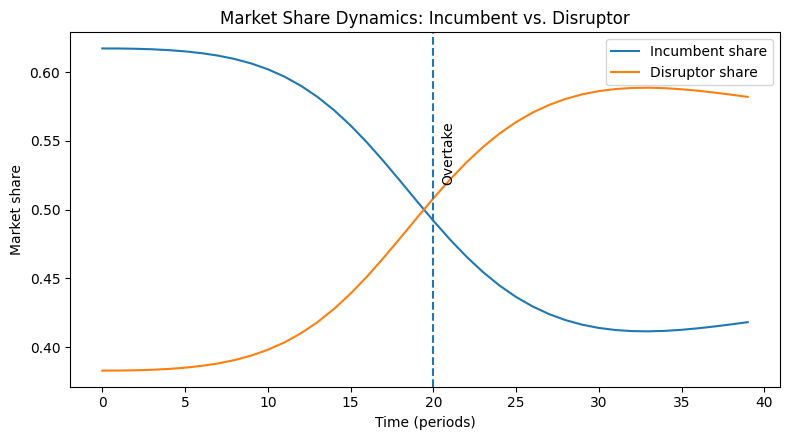

In [6]:
# Market Share Dynamics
plt.figure(figsize=(8, 4.5))
plt.plot(df["t"], df["Share_Incumbent"], label="Incumbent share")
plt.plot(df["t"], df["Share_Disruptor"], label="Disruptor share")
if stage_overtake is not None:
    plt.axvline(stage_overtake, linestyle="--")
    plt.text(stage_overtake + 0.5, 0.52, "Overtake", rotation=90)
plt.title("Market Share Dynamics: Incumbent vs. Disruptor")
plt.xlabel("Time (periods)")
plt.ylabel("Market share")
plt.legend()
plt.tight_layout()
plt.show()

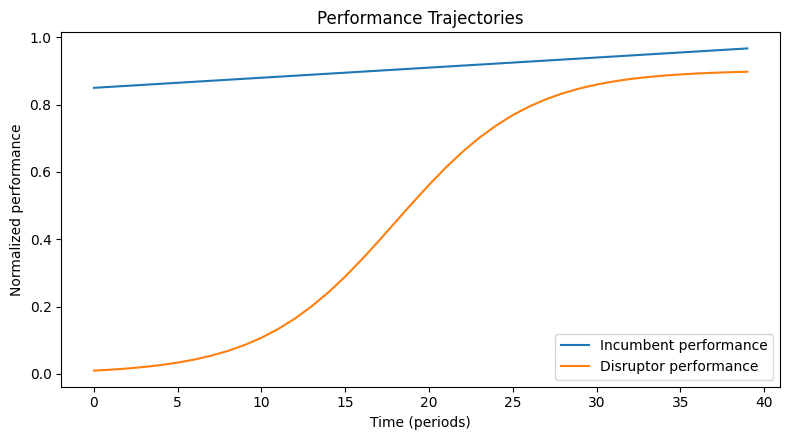

In [7]:
# Performance Trajectories
plt.figure(figsize=(8, 4.5))
plt.plot(df["t"], df["Perf_Incumbent"], label="Incumbent performance")
plt.plot(df["t"], df["Perf_Disruptor"], label="Disruptor performance")
if stage_good_enough is not None:
    plt.axvline(stage_good_enough, linestyle="--")
    plt.text(stage_good_enough + 0.5, 0.7, "Good enough", rotation=90)
plt.title("Performance Trajectories")
plt.xlabel("Time (periods)")
plt.ylabel("Normalized performance")
plt.legend()
plt.tight_layout()
plt.show()

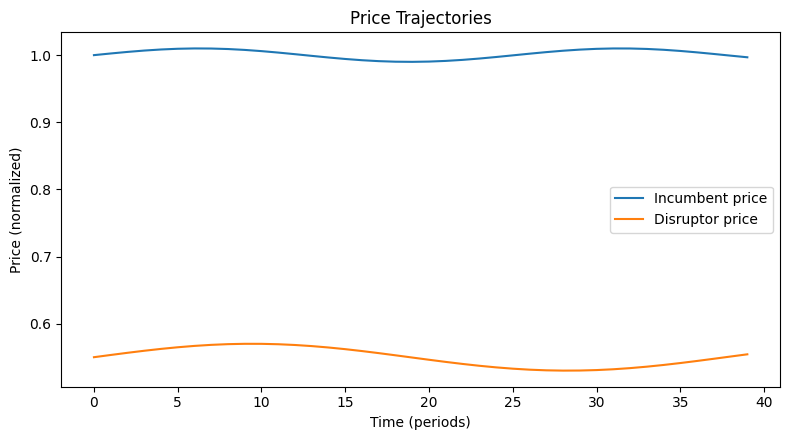

In [8]:

# Price Trajectories
plt.figure(figsize=(8, 4.5))
plt.plot(df["t"], df["Price_Incumbent"], label="Incumbent price")
plt.plot(df["t"], df["Price_Disruptor"], label="Disruptor price")
plt.title("Price Trajectories")
plt.xlabel("Time (periods)")
plt.ylabel("Price (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

# **Stage Markers & Data Snapshot**

In [9]:

from IPython.display import display
print("=== Disruption Stages (indices are time periods) ===")
for k, v in stages.items():
    print(f"{k}: {v}")
display(df.head(12))

=== Disruption Stages (indices are time periods) ===
Niche traction (share > 20%): 0
'Good enough' performance (~95% of incumbent): None
Overtakes incumbent (share > 50%): 20


,t,Perf_Incumbent,Perf_Disruptor,Price_Incumbent,Price_Disruptor,Share_Incumbent,Share_Disruptor
0,0,0.850,0.009916,1.000000,0.550000,0.617142,0.382858
1,1,0.853,0.012692,1.002474,0.553318,0.617098,0.382902
2,2,0.856,0.016233,1.004794,0.556544,0.616908,0.383092
3,3,0.859,0.020737,1.006816,0.559589,0.616536,0.383464
4,4,0.862,0.026454,1.008415,0.562367,0.615928,0.384072
5,5,0.865,0.033688,1.009490,0.564804,0.615017,0.384983
6,6,0.868,0.042802,1.009975,0.566829,0.613713,0.386287
7,7,0.871,0.054228,1.009840,0.568389,0.611904,0.388096
8,8,0.874,0.068462,1.009093,0.569439,0.609458,0.390542
9,9,0.877,0.086053,1.007781,0.569950,0.606219,0.393781


# Notes

*   The logistic S-curve captures how technologies often improve slowly at first, then rapidly, then taper off.

*   Two heterogeneous segments proxy how disruptors win low-end customers early (price advantage), then convert mainstream customers as performance becomes “good enough.”

*   The softmax choice model is a simple way to map utilities to market shares without overfitting the story.